
# Imputing missing values before building an estimator

Missing values can be replaced by the mean, the median or the most frequent
value using the basic :class:`~sklearn.impute.SimpleImputer`.

In this example we will investigate different imputation techniques:

- imputation by the constant value 0
- imputation by the mean value of each feature combined with a missing-ness
  indicator auxiliary variable
- k nearest neighbor imputation
- iterative imputation

We will use two datasets: Diabetes dataset which consists of 10 feature
variables collected from diabetes patients with an aim to predict disease
progression and California Housing dataset for which the target is the median
house value for California districts.

As neither of these datasets have missing values, we will remove some
values to create new versions with artificially missing data. The performance
of
:class:`~sklearn.ensemble.RandomForestRegressor` on the full original dataset
is then compared the performance on the altered datasets with the artificially
missing values imputed using different techniques.


In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

## Download the data and make missing values sets

First we download the two datasets. Diabetes dataset is shipped with
scikit-learn. It has 442 entries, each with 10 features. California Housing
dataset is much larger with 20640 entries and 8 features. It needs to be
downloaded. We will only use the first 400 entries for the sake of speeding
up the calculations but feel free to use the whole dataset.




In [1]:
import numpy as np

from sklearn.datasets import fetch_california_housing, load_diabetes

rng = np.random.RandomState(42)

X_diabetes, y_diabetes = load_diabetes(return_X_y=True)
X_california, y_california = fetch_california_housing(return_X_y=True)
X_california = X_california[:300]
y_california = y_california[:300]
X_diabetes = X_diabetes[:300]
y_diabetes = y_diabetes[:300]


def add_missing_values(X_full, y_full):
    n_samples, n_features = X_full.shape

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[:n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan
    y_missing = y_full.copy()

    return X_missing, y_missing


X_miss_california, y_miss_california = add_missing_values(X_california, y_california)

X_miss_diabetes, y_miss_diabetes = add_missing_values(X_diabetes, y_diabetes)

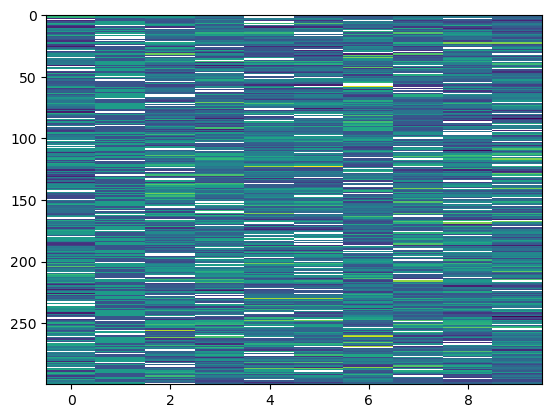

In [23]:
plt.imshow(X_miss_diabetes, aspect='auto', interpolation='nearest')

In [ ]:
import numpy as np

rng = np.random.RandomState(4152)



## Impute the missing data and score
Now we will write a function which will score the results on the differently
imputed data. Let's look at each imputer separately:




In [2]:
rng = np.random.RandomState(0)

from sklearn.ensemble import RandomForestRegressor

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

N_SPLITS = 4
regressor = RandomForestRegressor(random_state=0)

### Missing information
In addition to imputing the missing values, the imputers have an
`add_indicator` parameter that marks the values that were missing, which
might carry some information.




In [3]:
def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return impute_scores


x_labels = []

mses_california = np.zeros(5)
stds_california = np.zeros(5)
mses_diabetes = np.zeros(5)
stds_diabetes = np.zeros(5)

### Estimate the score
First, we want to estimate the score on the original data:




In [4]:
def get_full_score(X_full, y_full):
    full_scores = cross_val_score(
        regressor, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return full_scores.mean(), full_scores.std()


mses_california[0], stds_california[0] = get_full_score(X_california, y_california)
mses_diabetes[0], stds_diabetes[0] = get_full_score(X_diabetes, y_diabetes)
x_labels.append("Full data")

### Replace missing values by 0

Now we will estimate the score on the data where the missing values are
replaced by 0:




In [5]:
def get_impute_zero_score(X_missing, y_missing):
    imputer = SimpleImputer(
        missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0
    )
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()


mses_california[1], stds_california[1] = get_impute_zero_score(
    X_miss_california, y_miss_california
)
mses_diabetes[1], stds_diabetes[1] = get_impute_zero_score(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("Zero imputation")

### kNN-imputation of the missing values

:class:`~sklearn.impute.KNNImputer` imputes missing values using the weighted
or unweighted mean of the desired number of nearest neighbors.



In [6]:
def get_impute_knn_score(X_missing, y_missing):
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()


mses_california[2], stds_california[2] = get_impute_knn_score(
    X_miss_california, y_miss_california
)
mses_diabetes[2], stds_diabetes[2] = get_impute_knn_score(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("KNN Imputation")

### Impute missing values with mean




In [7]:
def get_impute_mean(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


mses_california[3], stds_california[3] = get_impute_mean(
    X_miss_california, y_miss_california
)
mses_diabetes[3], stds_diabetes[3] = get_impute_mean(X_miss_diabetes, y_miss_diabetes)
x_labels.append("Mean Imputation")

### Iterative imputation of the missing values

Another option is the :class:`~sklearn.impute.IterativeImputer`. This uses
round-robin linear regression, modeling each feature with missing values as a
function of other features, in turn.
The version implemented assumes Gaussian (output) variables. If your features
are obviously non-normal, consider transforming them to look more normal
to potentially improve performance.




In [8]:
def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(
        missing_values=np.nan,
        add_indicator=True,
        random_state=0,
        n_nearest_features=3,
        max_iter=1,
        sample_posterior=True,
    )
    iterative_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()


mses_california[4], stds_california[4] = get_impute_iterative(
    X_miss_california, y_miss_california
)
mses_diabetes[4], stds_diabetes[4] = get_impute_iterative(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("Iterative Imputation")

mses_diabetes = mses_diabetes * -1
mses_california = mses_california * -1

## Plot the results

Finally we are going to visualize the score:




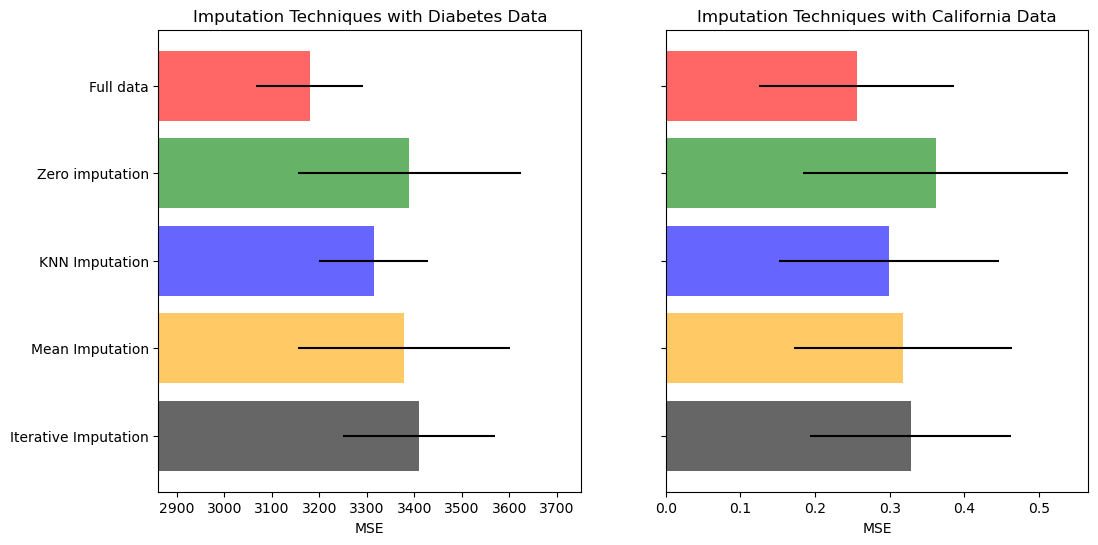

In [9]:
import matplotlib.pyplot as plt

n_bars = len(mses_diabetes)
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange", "black"]

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(
        j,
        mses_diabetes[j],
        xerr=stds_diabetes[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax1.set_title("Imputation Techniques with Diabetes Data")
ax1.set_xlim(left=np.min(mses_diabetes) * 0.9, right=np.max(mses_diabetes) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel("MSE")
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot california dataset results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(
        j,
        mses_california[j],
        xerr=stds_california[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax2.set_title("Imputation Techniques with California Data")
ax2.set_yticks(xval)
ax2.set_xlabel("MSE")
ax2.invert_yaxis()
ax2.set_yticklabels([""] * n_bars)

plt.show()

You can also try different techniques. For instance, the median is a more
robust estimator for data with high magnitude variables which could dominate
results (otherwise known as a 'long tail').

